# Google Analytics Data Analysis (BigQuery)

## Introduction - Understanding the problem

### Dataset Description

In this project, we will be working with the Google Analytics Sample Dataset hosted in Google BigQuery that can be found at:

`bigquery-public-data.google_analytics_sample.ga_sessions_20170801`

This dataset contains a single day (August 1, 2017) of anonymized Google Analytics session data for a fictional e-commerce store. It
includes information such as a) Traffic source data: where website visitors originate from, including data about organic traffic, paid search traffic, and display traffic b) Content data: information about the behavior of users on the site, such as URLs of pages that visitors look at, how they interact with content, etc. c) Transactional data: information about the transactions on the Google Merchandise Store website.

I'll be working with GoogleSQL along the project.

### Project Goal

The main goals of this analysis are to:
- Understand the behavior of users visiting the site. That could include questions such as which pages were viewed mostly? How long did they stay on each page? Did they click through that page / went back to the previous one / ended their session? Did they encounter issues? Are UX/UI changes that can help resolve these issues?
- Analyze traffic sources, user devices (for example mobile phone or laptop) and/or browsers, their location (e.g. country or city), and engagement. Knowing which traffic sources bring the most users and revenue can help both focus on them and make adjustments to improve the experience in the remaining sources.
- Can we identify any key factors leading to transactions and revenue generation? This could lead to business actions that optimize user acquisition, site engagement, and conversions.

## 1. Data Structure

We'll start by loading BigQuery:

In [3]:
%load_ext bigquery_magics
# To supress warnings and make our notebook more legible
import warnings
warnings.filterwarnings('ignore')
from google.cloud import bigquery
from google.oauth2 import service_account
# I'll use pandas to explore table structures, field values etc
import pandas as pd
# for plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
!pip install nbstripout -q

In [4]:
key_path = "data/week-3-bigquery-369916-341d3b137e42.json"

# Create credentials object
credentials = service_account.Credentials.from_service_account_file(key_path)

# Set context manually
from google.cloud.bigquery import magics
magics.context.credentials = credentials
magics.context.project = credentials.project_id

# data visualisation settings
pio.templates.default = "plotly_white"
color_palette = ['#8c4053', '#40798C','#a170a9', '#70A9A1']

In [5]:
%%bigquery df
-- Create a dataframe from the table - this will only be used to explore nested content, unique values etc
SELECT *
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`;

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   visitorId             0 non-null      Int64 
 1   visitNumber           2556 non-null   Int64 
 2   visitId               2556 non-null   Int64 
 3   visitStartTime        2556 non-null   Int64 
 4   date                  2556 non-null   object
 5   totals                2556 non-null   object
 6   trafficSource         2556 non-null   object
 7   device                2556 non-null   object
 8   geoNetwork            2556 non-null   object
 9   customDimensions      2556 non-null   object
 10  hits                  2556 non-null   object
 11  fullVisitorId         2556 non-null   object
 12  userId                0 non-null      object
 13  clientId              0 non-null      object
 14  channelGrouping       2556 non-null   object
 15  socialEngagementType  2556 non-null   

Going through the [Google Analytics documentation](https://support.google.com/analytics/answer/3437719?hl=en), we can see that `visitorId` is deprecated and hence null in this case, `userId` is a special feature designed to track a single user across multiple devices; a website needs explicit configurion to track it; `clientId` is an unhashed identifier. `fullVisitorId` is the primary identifier used by Google Analytics to track a unique client/device across multiple visits, as it is tied to the GA cookie stored in the user's browser.

The rest of the columns contain no null values, which is good. I won't be dropping the null ones, since I'll be working with SQL (therefore simply selecting the appropriate ones).


Let's look inside the `totals` column:

In [7]:
df['totals']

,totals
0,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time..."
1,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time..."
2,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time..."
3,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time..."
4,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time..."
...,...
2551,"{'visits': 1, 'hits': 84, 'pageviews': 60, 'ti..."
2552,"{'visits': 1, 'hits': 100, 'pageviews': 72, 't..."
2553,"{'visits': 1, 'hits': 140, 'pageviews': 93, 't..."
2554,"{'visits': 1, 'hits': 156, 'pageviews': 112, '..."


In [8]:
# Since 'totals' is a nested STRUCT, I'll expand it using json_normalize
df_totals = pd.json_normalize(df['totals'])

print(df_totals.columns)

Index(['visits', 'hits', 'pageviews', 'timeOnSite', 'bounces', 'transactions',
       'transactionRevenue', 'newVisits', 'screenviews', 'uniqueScreenviews',
       'timeOnScreen', 'totalTransactionRevenue', 'sessionQualityDim'],
      dtype='object')


We can see that `totals` contains session-level metrics, meaning these values summarize the activity that occurred during a single user session. Now let's look at `hits`. We already know that, by definition, a hit in Google Analytics refers to any user interaction with the website that results in data being sent to the Analytics server:

In [9]:
# Explore the hits column
df['hits']

,hits
0,"[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut..."
1,"[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut..."
2,"[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu..."
3,"[{'hitNumber': 1, 'time': 0, 'hour': 8, 'minut..."
4,"[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu..."
...,...
2551,"[{'hitNumber': 1, 'time': 0, 'hour': 18, 'minu..."
2552,"[{'hitNumber': 1, 'time': 0, 'hour': 9, 'minut..."
2553,"[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu..."
2554,"[{'hitNumber': 1, 'time': 0, 'hour': 15, 'minu..."


We see thtat `hits` is a list of dictionaries, let's look at an example:

In [10]:
# List the keys of the first hit
df['hits'].iloc[0][0].keys()

dict_keys(['hitNumber', 'time', 'hour', 'minute', 'isSecure', 'isInteraction', 'isEntrance', 'isExit', 'referer', 'page', 'transaction', 'item', 'contentInfo', 'appInfo', 'exceptionInfo', 'eventInfo', 'product', 'promotion', 'promotionActionInfo', 'refund', 'eCommerceAction', 'experiment', 'publisher', 'customVariables', 'customDimensions', 'customMetrics', 'type', 'social', 'latencyTracking', 'sourcePropertyInfo', 'contentGroup', 'dataSource', 'publisher_infos'])

`hits` appears to be a rather complex column. While the totals column summarized a session, the hits column contains a list of individual user actions that occurred during that session.

I'll now use SQL to see how many unique users we have, out of the 2556 rows (sessions):

In [11]:
%%bigquery

SELECT COUNT(DISTINCT fullVisitorId) AS unique_users
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`;

Query is running:   0%|          |

Downloading:   0%|          |

,unique_users
0,2293


Let's also use SQL to have a glimpse at the dataset (similar to the `head()` function in Python):

In [12]:
%%bigquery

SELECT *
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,<NA>,1,1501591568,1501591568,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'South...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut...",3418334011779872055,None,None,Organic Search,Not Socially Engaged
1,<NA>,2,1501589647,1501589647,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut...",2474397855041322408,None,None,Referral,Not Socially Engaged
2,<NA>,1,1501616621,1501616621,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'North...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",5870462820713110108,None,None,Referral,Not Socially Engaged
3,<NA>,1,1501601200,1501601200,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Firefox', 'browserVersion': 'not ...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 8, 'minut...",9397809171349480379,None,None,Referral,Not Socially Engaged
4,<NA>,1,1501615525,1501615525,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",6089902943184578335,None,None,Referral,Not Socially Engaged


We can see from the above that many fields are nested (like totals, device, geoNetwork).

Let's check the data types of the table attributes:

In [13]:
%%bigquery

SELECT
  column_name,
  data_type
FROM `bigquery-public-data.google_analytics_sample.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'ga_sessions_20170801';

Query is running:   0%|          |

Downloading:   0%|          |

,column_name,data_type
0,visitorId,INT64
1,visitNumber,INT64
2,visitId,INT64
3,visitStartTime,INT64
4,date,STRING
5,totals,"STRUCT<visits INT64, hits INT64, pageviews INT..."
6,trafficSource,"STRUCT<referralPath STRING, campaign STRING, s..."
7,device,"STRUCT<browser STRING, browserVersion STRING, ..."
8,geoNetwork,"STRUCT<continent STRING, subContinent STRING, ..."
9,customDimensions,"ARRAY<STRUCT<index INT64, value STRING>>"


The most important takeaway is that in many columns data is stored in a nested / semi-structured format, i.e. `STRUCT` and `ARRAY` data types. These columns must be flattened to perform analysis on them.

Let's have a look at some of the nested data in them:

In [14]:
%%bigquery

SELECT
  totals.visits,
  totals.pageviews,
  totals.transactionRevenue,
  device.deviceCategory,
  device.isMobile,
  trafficSource.source,
  trafficSource.medium,
  geoNetwork.country
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
LIMIT 5;


Query is running:   0%|          |

Downloading:   0%|          |

,visits,pageviews,transactionRevenue,deviceCategory,isMobile,source,medium,country
0,1,1,<NA>,desktop,False,(direct),(none),Greece
1,1,1,<NA>,desktop,False,analytics.google.com,referral,India
2,1,1,<NA>,desktop,False,analytics.google.com,referral,United Kingdom
3,1,1,<NA>,desktop,False,analytics.google.com,referral,United States
4,1,1,<NA>,desktop,False,adwords.google.com,referral,United States


With regards to `pageviews` in specific, some descriptive statistics are as follows:

In [15]:
%%bigquery

SELECT
  MIN(totals.pageviews) AS min_pageviews,
  MAX(totals.pageviews) AS max_pageviews,
  AVG(totals.pageviews) AS avg_pageviews,
  STDDEV(totals.pageviews) AS std_pageviews,
  COUNT(*) AS total_rows,
  COUNTIF(totals.pageviews IS NULL) AS null_count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`;


Query is running:   0%|          |

Downloading:   0%|          |

,min_pageviews,max_pageviews,avg_pageviews,std_pageviews,total_rows,null_count
0,1,155,4.279734,7.966343,2556,0


Similarly for `transactions`:

In [16]:
%%bigquery

SELECT
  MIN(totals.transactions) AS min_transactions,
  MAX(totals.transactions) AS max_transactions,
  AVG(totals.transactions) AS avg_transactions,
  STDDEV(totals.transactions) AS std_transactions,
  COUNT(*) AS total_rows,
  COUNTIF(totals.transactions IS NULL) AS null_count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`;

Query is running:   0%|          |

Downloading:   0%|          |

,min_transactions,max_transactions,avg_transactions,std_transactions,total_rows,null_count
0,1,2,1.046512,0.213083,2556,2513


It's important to note that in this dataset, `totals.transactionRevenue` is recorded in micro-units of the currency. Therefore we need to divide the sum by 10^6, in order to convert microdollars to dollars. The revenue metrics will therefore be calculated as follows:

In [17]:
%%bigquery

SELECT
  MIN(totals.transactionRevenue) / 1e6 AS min_transactionRevenue,
  MAX(totals.transactionRevenue) / 1e6 AS max_transactionRevenue,
  AVG(totals.transactionRevenue) / 1e6 AS avg_transactionRevenue,
  STDDEV(totals.transactionRevenue) / 1e6 AS std_transactionRevenue,
  COUNT(*) AS total_rows,
  COUNTIF(totals.transactionRevenue IS NULL) / 1e6 AS null_count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`;

Query is running:   0%|          |

Downloading:   0%|          |

,min_transactionRevenue,max_transactionRevenue,avg_transactionRevenue,std_transactionRevenue,total_rows,null_count
0,1.99,2933.61,193.13814,478.700758,2556,0.002513


## 2. Data Cleaning

How many sessions have missing user IDs (it's the `fullVisitorId` used for cookie tracking)?

In [18]:
%%bigquery

SELECT
  COUNT(*) AS sessions_missing_userid
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
WHERE fullVisitorId IS NULL;


Query is running:   0%|          |

Downloading:   0%|          |

,sessions_missing_userid
0,0


How many sessions have transactions recorded?

In [19]:
%%bigquery

SELECT
  COUNT(*) AS sessions_with_transactions
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
WHERE totals.transactions IS NOT NULL;


Query is running:   0%|          |

Downloading:   0%|          |

,sessions_with_transactions
0,43


How many sessions have pageviews?

In [20]:
%%bigquery

SELECT
  COUNT(*) AS sessions_with_pageviews
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
WHERE totals.pageviews IS NOT NULL;

Query is running:   0%|          |

Downloading:   0%|          |

,sessions_with_pageviews
0,2556


...which was expected! Now let's check for default 'na' placeholders:

In [21]:
%%bigquery

SELECT
  trafficSource.source,
  COUNT(*) AS session_count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
GROUP BY trafficSource.source
ORDER BY session_count DESC;


Query is running:   0%|          |

Downloading:   0%|          |

,source,session_count
0,(direct),2166
1,youtube.com,180
2,analytics.google.com,57
3,Partners,52
4,dfa,15
5,google.com,12
6,sites.google.com,8
7,facebook.com,7
8,quora.com,6
9,m.facebook.com,5


There is none present, which is good.

## 3. Exploratory Data Analysis (EDA)

In this section, we will investigate the business questions defined in the introduction, such as which traffic sources bring the most users and/or revenue? What device types are most common among buyers? Are new users or returning users more likely to make a purchase? Which countries generate the most sessions or revenue?

### Traffic Sources

To examine traffic sources, I'll start by a) aggregating sessions and revenue by `trafficSource.source` and `trafficSource.medium` and then b) rank sources by number of sessions and by transaction revenue.

In [22]:
%%bigquery

SELECT
    trafficSource.source,
    COUNT(*) AS session_count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
GROUP BY trafficSource.source
ORDER BY session_count DESC
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,source,session_count
0,(direct),2166
1,youtube.com,180
2,analytics.google.com,57
3,Partners,52
4,dfa,15


Once again, I divide sums by 10^6, in order to convert microdollars to dollars, prior to looking at revenue by traffic source:

In [23]:
%%bigquery
# Ranking traffic sources by revenue in million dollars

SELECT
    trafficSource.source,
    SUM(totals.transactionRevenue) / 1e6 AS sources_revenue_million
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
GROUP BY trafficSource.source
ORDER BY sources_revenue_million DESC
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,source,sources_revenue_million
0,(direct),8292.98
1,mail.google.com,11.96
2,ask,NaN
3,productforums.google.com,NaN
4,adwords.google.com,NaN


So (direct) traffic is the main source of visitors and generated \$8,292.98 of revenue; `mail.google.com` generated \$11.96 of revenue, while the remaining sources (`analytics.google.com`, etc.) generated no revenue.

In [24]:
%%bigquery
# ranking traffic by medium

SELECT
    trafficSource.medium,
    COUNT(*) AS session_count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
GROUP BY trafficSource.medium
ORDER BY session_count DESC
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,medium,session_count
0,(none),2166
1,referral,313
2,affiliate,52
3,cpm,15
4,organic,10


The different medium definitions are as follows:

| Medium    | Meaning |
|:----------|:--------|
| (none)    | Direct traffic (e.g. entering the URL directly) |
| referral  | Clicking on a link from another website |
| affiliate | Traffic from affiliate marketing partners |
| cpm       | Paid display ads (Cost per Mille = 1000 impressions) |
| organic   | Organic search (unpaid results from Google, etc.) |

### Device Analysis

We'll next breakdown sessions, transactions, and revenue by device Category and whether the device was mobile or not:

In [25]:
%%bigquery df

SELECT
  device.deviceCategory AS device_category,
  COUNT(*) AS device_count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
GROUP BY device_category
ORDER BY device_count DESC;

Query is running:   0%|          |

Downloading:   0%|          |

Let's plot the device sources

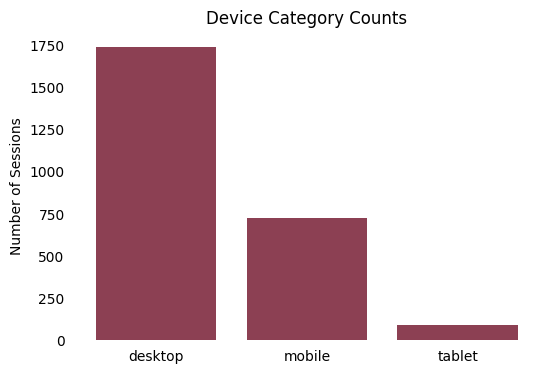

In [26]:
plt.figure(figsize=(6, 4))
plt.bar(
    df['device_category'],
    df['device_count'],
    color=color_palette[0]
)

# labels and title
plt.ylabel("Number of Sessions")
plt.title("Device Category Counts")

# remove surrounding bounding box / spines
ax = plt.gca()
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(left=False, bottom=False)

plt.xticks(rotation=0)
plt.show()

In [27]:
%%bigquery

SELECT
  device.isMobile,
  COUNT(*) AS device_count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
GROUP BY device.isMobile
ORDER BY device_count DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,isMobile,device_count
0,False,1741
1,True,815


The results show that approximately 2/3 of the sessions come from Desktop devices, whereas mobiles and tablets account for the remaining 1/3.

### User Type Analysis

In order to tell if a user is new or returning, we'll use the totals.newVisits column, where:
- 1 = New visitor
- NULL = Returning visitor

I'll also create a metric to calculate conversion rates. This will be:
a) the number of transactions per visit (Conversion Rate = transactions/sessions) and
b) the revnue of transactions per visit, for the two visitor categories defined above.

In [28]:
%%bigquery

SELECT
    CASE WHEN
        totals.newVisits = 1 THEN 'new_visitors'
        ELSE 'returning_visitor'
    -- Create a new column
    END AS user_type,
    COUNT(*) AS returning_user_count,
    SUM(totals.transactions) AS total_transactions,
    SUM(totals.transactions) / COUNT(*) AS conversion_rate,
    SUM(totals.transactionRevenue) / 1e6 AS transaction_revenue_visitor,
    SUM(totals.transactionRevenue) / 1e6 / COUNT(*) AS transaction_revenue_per_visitor
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
GROUP BY user_type
ORDER BY transaction_revenue_visitor DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,user_type,returning_user_count,total_transactions,conversion_rate,transaction_revenue_visitor,transaction_revenue_per_visitor
0,returning_visitor,684,34,0.049708,7630.46,11.155643
1,new_visitors,1872,11,0.005876,674.48,0.360299


So we have 1872 new users and 684 returning users. From the table we can see that returning visitors are significantly more valuable that new visitors because:
1. They  make way more purchases (34 transactions vs 11)
2. Their conversion rate (\~4.97%) is almost 8.5x higher than new visitors (\~0.59%)
3. Returning visitors generated \$7630, compared to \$674 for new visitors.
4. And finally, returning visitors spend \$11.16 per session, whereas new visitors spend only \$0.36 per session.

That's an important conclusion to draw!

### Geographic Analysis

In [29]:
%%bigquery

SELECT
    geoNetwork.country,
    COUNT(*) AS country_count,
    SUM(totals.transactionRevenue)  / 1e6 AS revenue_per_country,
    SUM(totals.transactions) / COUNT(*) AS transactions_session,
    SUM(totals.transactionRevenue) / 1e6 / COUNT(*) AS transaction_revenue_per_visitor
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
GROUP BY geoNetwork.country
ORDER BY transaction_revenue_per_visitor DESC
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,country,country_count,revenue_per_country,transactions_session,transaction_revenue_per_visitor
0,United States,1287,8301.95,0.034188,6.450622
1,Finland,2,2.99,0.500000,1.495000
2,India,155,NaN,NaN,NaN
3,Mexico,27,NaN,NaN,NaN
4,United Kingdom,142,NaN,NaN,NaN


The results show that the United States is clearly the primary market (both in traffic and revenue). Users from Finland have very high conversion rates, so it's worth investigating as a market. Other countries have decent traffic (like India and UK) but currently not converting.

### Bounce

Bounce rate represents the percentage of visitors who enter the site and then leave ("bounce") rather than continuing to view other pages within the same site. It is calculated by counting the number of single page visits and dividing that by the total visits. It is then represented as a percentage of total visits.

In [30]:
%%bigquery bounce_df
--I'll use a Common Table Expression (CTE) to create a temporary result set for bounce data

WITH bounce_table AS (
    SELECT
        trafficSource.medium,
        CASE WHEN totals.pageviews = 1 THEN 1 ELSE 0 END AS is_bounce
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
)
SELECT
    medium,
    COUNT(*) AS session_count,
    SUM(is_bounce) AS total_bounce,
    ROUND(SAFE_DIVIDE(SUM(is_bounce), COUNT(*)) * 100, 1) AS bounce_ratio
FROM bounce_table
GROUP BY medium
ORDER BY bounce_ratio DESC;


Query is running:   0%|          |

Downloading:   0%|          |

In [31]:
bounce_df

,medium,session_count,total_bounce,bounce_ratio
0,referral,313,211,67.4
1,organic,10,6,60.0
2,affiliate,52,30,57.7
3,(none),2166,990,45.7
4,cpm,15,6,40.0


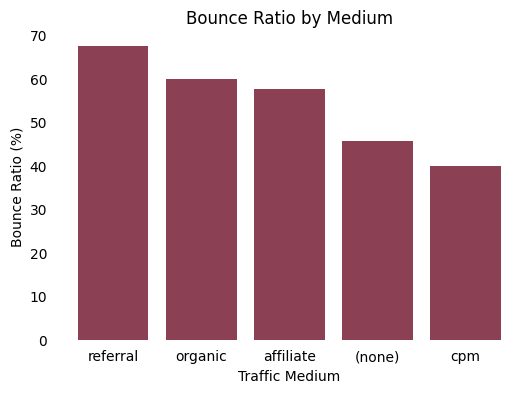

In [32]:
plt.figure(figsize=(6, 4))
plt.bar(
    bounce_df['medium'],
    bounce_df['bounce_ratio'],
    color=color_palette[0]
)

plt.xlabel("Traffic Medium")
plt.ylabel("Bounce Ratio (%)")
plt.title("Bounce Ratio by Medium")

# remove bounding box
ax = plt.gca()
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(left=False, bottom=False)

plt.xticks(rotation=0)
plt.show()

These results show that:
- Referral traffic has the highest bounce rate (67.4%). These are users that find the site organically, such as links from other websites, mentions on social media etc. A possible cause might be that the landing page of the fictional e-commerce store does not meet user expectations.
- Organic traffic bounce rate is also quite high (60%). This refers to all traffic that comes from a search engine and which was not sponsored (not an ad). The underlying cause might be bad SEO targeting or (amilar to before) poor first page experience.
- Affiliate traffic is bouncing a lot too (57.7%). This traffic is generated by affiliates (i.e. other websites), which receive a commission for each visit or conversion (e.g. signup or sale) they generate for the target website.
- The fact that direct traffic ("none") is also higher than expected (45.7%) makes it even more likely that the landing page needs improvement.
So let's investigate the landing pages further:

### Landing Page Bounce Analysis

It would be useful to investigate which of the pages that users land on the website have high bounce rates, so that web design and UX improvements can be targeted to them:

In [33]:
%%bigquery

WITH bounce_stats AS(
SELECT
  h.page.pagePath AS landing_page,
  COUNT(DISTINCT visitId) AS total_sessions,
  SUM(CASE WHEN totals.pageViews = 1 THEN 1 ELSE 0 END) AS total_bounces
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
CROSS JOIN
  UNNEST(hits) AS h
WHERE
  h.hitNumber = 1
GROUP BY
  landing_page
)

SELECT
  *,
  ROUND(SAFE_DIVIDE(total_bounces, total_sessions) * 100,1)  AS bounce_rate
FROM
  bounce_stats
WHERE
  total_sessions >= 10
ORDER BY
  bounce_rate DESC


Query is running:   0%|          |

Downloading:   0%|          |

,landing_page,total_sessions,total_bounces,bounce_rate
0,/google+redesign/electronics,20,14,70.0
1,/asearch.html,10,7,70.0
2,/google+redesign/drinkware,23,15,65.2
3,/google+redesign/shop+by+brand/youtube,588,363,61.7
4,/store.html,23,14,60.9
5,/google+redesign/lifestyle/fun/malibu+sunglass...,10,6,60.0
6,/google+redesign/bags/backpacks/home,14,8,57.1
7,/google+redesign/apparel/mens,11,6,54.5
8,/google+redesign/electronics/audio/google+g+no...,13,7,53.8
9,/google+redesign/accessories/stickers/home,23,12,52.2


- Page `/google+redesign/shop+by+brand/youtube` needs to be investigated as it has both high traffic and bounce rates.
- Pages like `/google+redesign/electronics`, `/asearch.html`, and `/google+redesign/drinkware` all have bounce rates above 65%. This may indicate that a)they offer a poor landing page experience (irrelevant content, slow loading) or b) their content is not consistent with what the user expects being directed to them.
- Pages such as `/basket.html` (28.6%) and `/signin.html` (23.1%) have very low bounce rates, which makes sense because they are not part of the general user navigation but rather part of a specific goal of the user.

### Session Duration / Time on Site

It's interesting to investigate which pages engage the users most with:

In [34]:
%%bigquery
WITH session_time AS(
SELECT
  visitId,
  MIN(h.time) / 1000 AS session_start_time_seconds,
  MAX(h.time) / 1000 AS session_end_time_seconds,
  CASE
    WHEN COUNT(h.time) = 1 THEN 0
    ELSE (MAX(h.time) - MIN(h.time)) / 1000
  END AS session_duration_seconds,
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
CROSS JOIN
  UNNEST(hits) AS h
WHERE
  -- Only real interactions
  h.isInteraction IS TRUE
GROUP BY
  visitId
ORDER BY
  session_duration_seconds DESC
)

SELECT
  AVG(session_duration_seconds) AS average_session_duration
FROM
  session_time


Query is running:   0%|          |

Downloading:   0%|          |

,average_session_duration
0,169.279599


### Session Duration by Channel/Device/Page

How is the time a user spends on the site affected by the traffic channel, their device or page they come from? Let's find out below:

In [35]:
%%bigquery

WITH session_time AS(
SELECT
  visitId,
  MIN(h.time) / 1000 AS session_start_time_seconds,
  MAX(h.time) / 1000 AS session_end_time_seconds,
  CASE
    WHEN COUNT(h.time) = 1 THEN 0
    ELSE (MAX(h.time) - MIN(h.time)) / 1000
  END AS session_duration_seconds,
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
  -- Use cross join to explode an array into rows
CROSS JOIN
  UNNEST(hits) AS h
WHERE
  -- Only real interactions
  h.isInteraction IS TRUE
GROUP BY
  visitId
ORDER BY
  session_duration_seconds DESC
)

SELECT
  trafficSource.source,
  AVG(session_duration_seconds) AS avg_session_duration
FROM
  session_time
JOIN
  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801` AS t
ON
  session_time.visitId = t.visitId
GROUP BY
  trafficSource.source
ORDER BY
  avg_session_duration DESC
LIMIT 20;


Query is running:   0%|          |

Downloading:   0%|          |

,source,avg_session_duration
0,mail.google.com,736.833500
1,dealspotr.com,656.197000
2,groups.google.com,306.040000
3,facebook.com,300.494429
4,m.facebook.com,282.543600
5,away.vk.com,223.079000
6,qiita.com,207.634000
7,bing,205.120000
8,(direct),188.420978
9,dfa,157.198733


These results show that:

- `mail.google.com` (736 seconds) and `dealspotr.com` (656 seconds) stand out with high average session durations - over 10 minutes and almost 11 minutes, respectively. This suggests either very high user intent or that users likely clicked through targeted or interesting content.
- `m.facebook.com` (mobile Facebook) shows slightly lower session duration (282s) compared to desktop Facebook (300s). This is to be expected, as mobile users generally have shorter sessions due to different browsing habits.
- `bing` (205s) and `google.com` (76s) show lower average session times compared to direct referral links. Organic searchers may be looking for quick answers rather than deep engagement.

### Hits

As explained earlier, a hit in Google Analytics refers to *any user interaction with the website that results in data being sent to the Analytics server*, such as viewing a page or clicking a button. Below we'll calculate average page and event (e.g. clicks, video plays, downloads, etc.) hits per session (visit).

In [36]:
%%bigquery
-- Let's calculate average page and event hits per session

WITH hit_table AS(
    SELECT
        visitId,
        SUM(CASE WHEN h.type = 'PAGE' THEN 1 ELSE 0 END) AS page_hits,
        SUM(CASE WHEN h.type = 'EVENT' THEN 1 ELSE 0 END) AS event_hits,
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`,
    UNNEST(hits) AS h
    GROUP BY visitId
)

SELECT
    ROUND(AVG(page_hits), 2) AS avg_page_hits_per_session,
    ROUND(AVG(event_hits), 2) AS avg_event_hits_per_session,
    COUNT(*) AS total_sessions
FROM
    hit_table;


Query is running:   0%|          |

Downloading:   0%|          |

,avg_page_hits_per_session,avg_event_hits_per_session,total_sessions
0,4.36,0.91,2509


From these results we conclude that we have 4.36 pageviews per session, which is considered normal to good in web analytics. A good score is often between 3-5 pages per session, but that depends on the nature of the website of course. We can also see that there is user interaction, as 0.91 events per session means almost every session triggers an event (clicks, video plays, etc.). Therefore visitors are not being passive.

### How are hit events related to transactions and revenue?

I'll start by examining whether clicking events are related to conversion, by calculating the following metrics:
- Overall average events per session
- Average events per session where conversion took place
- Total conversion rate
- Average revenue per session

In [37]:
%%bigquery

WITH session_summary AS (
    SELECT
        fullVisitorId,
        visitId,
        SUM(CASE WHEN h.type = 'EVENT' THEN 1 ELSE 0 END) AS event_count,
        IFNULL(totals.transactions, 0) AS transactions,
        IFNULL(totals.transactionRevenue, 0) / 1e6 AS transaction_revenue -- GA stores revenue in micros (divide by 1M)
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`,
    UNNEST(hits) AS h
    GROUP BY fullVisitorId, visitId, totals.transactions, totals.transactionRevenue
)

SELECT
    ROUND(AVG(event_count), 2) AS avg_events_per_session,
    ROUND(AVG(CASE WHEN transactions > 0 THEN event_count ELSE NULL END), 2) AS avg_events_in_converting_sessions,
    ROUND(SUM(transactions) / COUNT(*), 4) AS conversion_rate,
    ROUND(SUM(transaction_revenue) / COUNT(*), 2) AS avg_revenue_per_session
FROM
    session_summary;


Query is running:   0%|          |

Downloading:   0%|          |

,avg_events_per_session,avg_events_in_converting_sessions,conversion_rate,avg_revenue_per_session
0,0.9,10.37,0.0176,3.25


These results show that there is a big difference in engagement: The typical session has about 1 event, but events with a transaction (converting sessions) have over 10 events on average! In other words, more engaged sessions (users who trigger many events) are far more likely to convert. Conversion rate is approximately 1.76%, which is [generally considered](https://business.adobe.com/blog/basics/ecommerce-conversion-rate-benchmarks) acceptable for ecommerce or lead generation websites, as industry benchmarks often range 1%–3%. Finally, the average revenue per session (\$3.25) should be evaluated based on the products sold. As this ecommerce site sells hoodies etc. (priced around \$30-40 USD), we could consider this average as acceptable.

### Event breakdown

In Google Analytics data (in this case GA3, which the sample dataset is from), event data is hierarchically organized as follows:
- Event Category (broad category)
- Event Action (what the user did inside the category)
- Event Label (additional description detail)

So I'll start by exploring the hit types, grouping them in that order, counting the number of times they occured and displaying the conversion event ratios:

In [38]:
%%bigquery

WITH event_data AS (
    SELECT
        h.eventInfo.eventCategory AS event_category,
        h.eventInfo.eventAction AS event_action,
        h.eventInfo.eventLabel AS event_label,
        IFNULL(totals.transactions, 0) AS transactions
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`,
        UNNEST(hits) AS h
    WHERE
        h.type = 'EVENT'
)

SELECT
    event_category,
    event_action,
    event_label,
    COUNT(*) AS total_event_occurrences,
    -- Mark the sessions that had transactions
    SUM(CASE WHEN transactions > 0 THEN 1 ELSE 0 END) AS event_in_converting_sessions,
    -- Give the ratio of the events that had transactions to the total event occurences
    ROUND(SAFE_DIVIDE(SUM(CASE WHEN transactions > 0 THEN 1 ELSE 0 END), COUNT(*)) * 100, 1) AS conversion_event_ratio
FROM
    event_data
GROUP BY
    event_category, event_action, event_label
ORDER BY
    event_in_converting_sessions DESC
LIMIT 10;


Query is running:   0%|          |

Downloading:   0%|          |

,event_category,event_action,event_label,total_event_occurrences,event_in_converting_sessions,conversion_event_ratio
0,Enhanced Ecommerce,Add to Cart,None,494,175,35.4
1,Enhanced Ecommerce,Product Click,None,411,64,15.6
2,Enhanced Ecommerce,Remove from Cart,None,75,22,29.3
3,Enhanced Ecommerce,Quickview Click,Google Infant Short Sleeve Tee Green,10,10,100.0
4,Enhanced Ecommerce,Quickview Click,Google Men's Zip Hoodie,18,9,50.0
5,Enhanced Ecommerce,Quickview Click,Google Men's 100% Cotton Short Sleeve Hero Tee...,38,7,18.4
6,Enhanced Ecommerce,Quickview Click,Google Canvas Tote Natural/Navy,17,7,41.2
7,Enhanced Ecommerce,Quickview Click,Google Women's Performance Full Zip Jacket Black,13,6,46.2
8,Enhanced Ecommerce,Quickview Click,Google Youth Baseball Raglan Heather/Black,7,5,71.4
9,Enhanced Ecommerce,Quickview Click,Google Tote Bag,9,5,55.6


From the above table we can draw that users who added to cart were much more likely to convert (which makes sense), as they have a 35.4% conversion ratio. "Quickview Click" events in particular (i.e. on individual products) have high conversion ratios (some range between 50–100%).

### Funnel exploration

Funnel exploration lets us understand the steps users of a website take to complete a task, in this case conversion (a transaction) and evaluate how many users drop off between each step. For this purpose, I'll examine the chained sequence of the following:

1. Product click or Quickview click (note: there is no guaranteed sequence between Product click and Quickview click, so in reality this would depend on the functionality of the website)
2. Add to Cart
3. Transaction

In [39]:
%%bigquery

WITH funnel_data AS (
    SELECT
        visitId,
        -- If at least 1 of the following events has taken place, assign the value 1
        MAX(CASE WHEN h.eventInfo.eventAction = 'Product Click' THEN 1 ELSE 0 END) AS product_click_count,
        MAX(CASE WHEN h.eventInfo.eventAction = 'Quickview Click' THEN 1 ELSE 0 END) AS quickview_click_count,
        MAX(CASE WHEN h.eventInfo.eventAction = 'Add to Cart' THEN 1 ELSE 0 END) AS add_to_cart_count,
        IFNULL(MAX(totals.transactions), 0) AS transaction_total
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`,
        UNNEST(hits) AS h
    WHERE
        h.type = 'EVENT'
    GROUP BY
        visitId
)

SELECT
    COUNT(DISTINCT visitId) AS total_visits,
    SUM(CASE WHEN product_click_count=1 OR quickview_click_count=1 THEN 1 ELSE 0 END) AS product_or_quickview_session,
    SUM(CASE WHEN (product_click_count=1 OR quickview_click_count=1) AND add_to_cart_count=1 THEN 1 ELSE 0 END) AS product_or_quickview_and_cart_session,
    SUM(CASE WHEN (product_click_count=1 OR quickview_click_count=1) AND add_to_cart_count=1 AND transaction_total>0 THEN 1 ELSE 0 END) AS product_or_quickview_cart_transaction_session
FROM
    funnel_data;


Query is running:   0%|          |

Downloading:   0%|          |

,total_visits,product_or_quickview_session,product_or_quickview_and_cart_session,product_or_quickview_cart_transaction_session
0,480,430,152,30


The results show that one out of three users (152/430 = 35.3%) who interacted went on to add a product to cart; in addition, approximately only one out of five users (30/152 = 19.7%) who added a product in the cart went on to complete the transaction.

Let's further explore the sessions that were the most engaging in terms of pageviews, and led to a transaction:

In [40]:
%%bigquery

WITH average_pageviews AS (
  SELECT AVG(totals.pageviews) AS avg_pageviews
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
    WHERE totals.pageviews IS NOT NULL
)

SELECT
  fullVisitorId,
  visitId,
  totals.pageviews,
  avg_pageviews,
  totals.transactions,
  totals.transactionRevenue / 1e6 AS revenue
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
CROSS JOIN
  average_pageviews
WHERE
  totals.transactions IS NOT NULL
  AND totals.pageviews > (
    SELECT AVG(totals.pageviews) AS avg_pageviews
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
    WHERE totals.pageviews IS NOT NULL
  )
ORDER BY
  revenue DESC
LIMIT 10;



Query is running:   0%|          |

Downloading:   0%|          |

,fullVisitorId,visitId,pageviews,avg_pageviews,transactions,revenue
0,9308310352918219134,1501608078,55,4.279734,1,2933.61
1,0126612099954375841,1501606687,32,4.279734,1,1000.78
2,7311242886083854158,1501623886,17,4.279734,1,982.73
3,7420300501523012460,1501627131,112,4.279734,1,400.21
4,4871061239735971842,1501604340,18,4.279734,1,347.14
5,8719058463049309640,1501602101,27,4.279734,1,313.38
6,5371617068925994598,1501631449,23,4.279734,1,234.53
7,454845221896711463,1501608216,13,4.279734,1,200.00
8,9008243837280281377,1501624252,34,4.279734,1,170.39
9,7420300501523012460,1501640730,21,4.279734,1,169.90


In [45]:
labels = [
    "Total Visits",
    "Product or Quickview",
    "Added to Cart",
    "Transactions"
]

values = [480, 430, 152, 30]

fig = go.Figure(go.Funnel(
    y=labels,
    x=values,
    textinfo="value+percent initial",
    orientation="h",
    marker=dict(color=color_palette[1])
))

fig.update_layout(
    title="User Journey Funnel",
    width=900,
    height=500
)

fig.show()

## Conclusions

In this project, we performed an in-depth analysis of a Google Analytics sample dataset using BigQuery and SQL. The goal was to understand user behavior, traffic sources, engagement patterns, and factors leading to revenue generation. The main conclusions are summarized below:

### Traffic Sources
Direct traffic was the dominant source, contributing the highest number of sessions and the majority of revenue (\$8,292.98). `mail.google.com` also generated some revenue, though much smaller in scale. Most other sources, including `analytics.google.com` and `adwords.google.com`, contributed little or no revenue during the observed period.

### Devices Used
Desktop devices accounted for approximately two-thirds of sessions, while mobile and tablet users made up the remaining third. Despite lower session counts, mobile users demonstrated considerable engagement, indicating the importance of maintaining a strong mobile user experience.

### User Types
Returning visitors proved to be significantly more valuable than new visitors, as their conversion rates were approximately 8.5 times higher than for new users. Returning visitors also generated substantially higher revenue per session (\$11.16 versus \$0.36).

This suggests that retention efforts (e.g., loyalty programs, targeted campaigns) could have a major impact on overall business performance.

### Geographic Insights

United States was by far the leading market, accounting for both the highest number of sessions and the largest amount of revenue Finland had an unusually high conversion rate relative to its small number of sessions, suggesting potential for targeted marketing in niche markets.

### Bounce Rates and Landing Pages

Referral and organic traffic had the highest bounce rates, suggesting possible mismatches between user expectations and landing page content. Specific landing pages, such as `/google+redesign/electronics` and `/asearch.html`, exhibited high bounce rates (above 65%), making them candidates for UX review and improvement.

### Session Duration and Engagement
Sessions referred by `mail.google.com` and `dealspotr.com` had the highest average session durations, suggesting strong engagement when users arrived from these sources. Direct traffic showed moderate engagement compared to organic and paid channels. It's important to note that high session durations correlated with higher conversion likelihood, so user engagement should be encouraged!

In addition, events like "Add to Cart" and "Product Click" were strongly associated with conversions. Sessions where users triggered multiple events (especially more than 10) had significantly higher conversion rates compared to sessions with minimal interaction.

### Funnel Analysis

Finally, with regards to the funnel analysis, we can draw that:
- Only about 35% of users who interacted with a product (via click or quickview) proceeded to add it to the cart.
- Of those who added a product to the cart, only 20% completed a transaction.

This points to potential drop-off points in the purchase funnel where targeted interventions (e.g., retargeting, promotions, cart abandonment emails) could improve conversion rates.

